In [1]:
import h5py
import os
import sys
import tensorflow as tf
import numpy as np
from bm3d import bm3d_rgb, BM3DProfile
module_dir = "/global/u2/k/kberard/SCGSR/Research/Diamond/stock_models/bm3d-4.0.3/bm3d-4.0.3/examples" 
sys.path.insert(0, module_dir)
from experiment_funcs import get_experiment_noise, get_psnr, get_cropped_psnr
from PIL import Image
import matplotlib.pyplot as plt


2025-07-22 09:04:23.763296: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753200263.776906  631085 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753200263.781271  631085 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753200263.793367  631085 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753200263.793380  631085 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753200263.793382  631085 computation_placer.cc:177] computation placer alr

In [2]:
import math
import torch
import torch.nn as nn
import numpy as np
from thop import profile
from einops import rearrange 
from einops.layers.torch import Rearrange, Reduce
from timm.models.layers import trunc_normal_, DropPath

/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
print("here")

here


In [2]:
#image denoise methods to try
#arciteture only 2024 https://www.nature.com/articles/s41598-024-60139-x
# cascaded gaze 2019 https://github.com/Ascend-Research/CascadedGaze
# SwinIR 2021 https://github.com/JingyunLiang/SwinIR?tab=readme-ov-file
#scunet, ffdnet (compared in nature paper, very close to nat perf) or dnCNN  toolbox with many models https://github.com/cszn/KAIR
#scunet it python based 
# https://pypi.org/project/bm3d/ Bm3d also in nature paper

In [4]:
# minorized reference
with h5py.File('/global/u2/k/kberard/SCGSR/Research/Diamond/Data/density_tot_ref.h5', 'r') as file:
    #print("Keys: %s" % file.keys())
    ref_d = file['density'][:]
#print(ref_d)
print(ref_d.shape)




(64, 64, 64)


In [5]:
####################################################################################################################################################
def stochastic_density(d,N):
    # poisson model
    #  accurate and fast for all values of N
    # N  = number of MC samples
    assert isinstance(d,np.ndarray)
    assert isinstance(N,(int,float,np.int64,np.float64))
    assert N>0
    ds = np.random.poisson(N*d)/N
    ds*= d.sum()/ds.sum()
    return ds
#end def stochastic_density

####################################################################################################################################################

In [6]:
def generate_single_2d_density(ref_d, noise_level):
    noisy_3d = stochastic_density(ref_d, noise_level)  # shape: (64, 64, 64)
    return noisy_3d

# Noise levels to randomly draw from
noise_levels = [10000 * (j + 1) for j in range(5)]  # [10000, 20000, ..., 50000]

# Sizes
num_train = 5000
num_val = 1000
num_test = 500

# Generate train set with mixed noise levels
x_train = np.zeros((num_train, 64, 64,64))
for i in range(num_train):
    noise_level = np.random.choice(noise_levels)
    x_train[i] = generate_single_2d_density(ref_d, noise_level)

# Generate val set with mixed noise levels
x_val = np.zeros((num_val, 64, 64,64))
for i in range(num_val):
    noise_level = np.random.choice(noise_levels)
    x_val[i] = generate_single_2d_density(ref_d, noise_level)



print("Train, val, generated")


Train, val, generated


In [7]:
# Generate test set with fixed noise level
x_test = np.zeros((num_test, 64, 64, 64))
for i in range(num_test):
    x_test[i] = generate_single_2d_density(ref_d, 100000)
print("test generated")

test generated


In [8]:
print(ref_d.shape)

(64, 64, 64)


In [9]:
y_test_3d = np.zeros((x_test.shape[0],64,64,64))
y_train_3d = np.zeros((x_train.shape[0],64,64,64))
y_val_3d = np.zeros((x_val.shape[0],64,64,64))
for i in range (y_test_3d.shape[0]):
    y_test_3d[i]=stochastic_density(ref_d,1000000)
y_test = y_test_3d
for i in range (y_train_3d.shape[0]):
    y_train_3d[i]=stochastic_density(ref_d,1000000)
y_train = y_train_3d

for i in range (y_val_3d.shape[0]):
    y_val_3d[i]=stochastic_density(ref_d,1000000)
y_val = y_val_3d
print("here")

here


In [10]:
import numpy as np

def batch_project_3d_to_rgb(x_train_3d, x_val_3d, x_test_3d,
                            y_train_3d, y_val_3d, y_test_3d,
                            ref_d=None, buffer_scale=1.01):
    """
    Projects all input and output 3D densities to 2D RGB with per-sample normalization.
    Optionally includes a single reference density `ref_d`.

    Args:
        x_train_3d, x_val_3d, x_test_3d, y_train_3d, y_val_3d, y_test_3d: ndarray of shape (N, H, W, D)
        ref_d: ndarray of shape (H, W, D), optional reference sample
        buffer_scale: float, buffer for normalization (default 1.01)

    Returns:
        Tuple of normalized RGB arrays in order:
        x_train_rgb, x_val_rgb, x_test_rgb,
        y_train_rgb, y_val_rgb, y_test_rgb,
        ref_d_rgb (or None if not provided)
    """
    def split_sum_rgb(x_3d):
        N, H, W, D = x_3d.shape
        thirds = np.array_split(np.arange(D), 3)
        r = np.sum(x_3d[:, :, :, thirds[0]], axis=-1)
        g = np.sum(x_3d[:, :, :, thirds[1]], axis=-1)
        b = np.sum(x_3d[:, :, :, thirds[2]], axis=-1)
        return np.stack([r, g, b], axis=-1)

    def normalize_per_sample(x_rgb):
        max_vals = np.max(x_rgb, axis=(1, 2, 3), keepdims=True)
        max_vals = np.where(max_vals == 0, 1.0, max_vals)  # Prevent div by zero
        return np.clip(x_rgb / (max_vals * buffer_scale), 0, 1)

    def single_project_3d_to_rgb(x_3d_single):
        thirds = np.array_split(np.arange(x_3d_single.shape[-1]), 3)
        r = np.sum(x_3d_single[:, :, thirds[0]], axis=-1)
        g = np.sum(x_3d_single[:, :, thirds[1]], axis=-1)
        b = np.sum(x_3d_single[:, :, thirds[2]], axis=-1)
        rgb = np.stack([r, g, b], axis=-1)
        max_val = np.max(rgb)
        return np.clip(rgb / (max_val * buffer_scale if max_val > 0 else 1.0), 0, 1)

    # Convert to RGB
    x_train_rgb = normalize_per_sample(split_sum_rgb(x_train_3d))
    x_val_rgb   = normalize_per_sample(split_sum_rgb(x_val_3d))
    x_test_rgb  = normalize_per_sample(split_sum_rgb(x_test_3d))
    y_train_rgb = normalize_per_sample(split_sum_rgb(y_train_3d))
    y_val_rgb   = normalize_per_sample(split_sum_rgb(y_val_3d))
    y_test_rgb  = normalize_per_sample(split_sum_rgb(y_test_3d))

    # Optional: process ref_d
    ref_d_rgb = single_project_3d_to_rgb(ref_d) if ref_d is not None else None

    return (
        x_train_rgb, x_val_rgb, x_test_rgb,
        y_train_rgb, y_val_rgb, y_test_rgb,
        ref_d_rgb
    )


In [11]:
x_train_rgb, x_val_rgb, x_test_rgb, \
y_train_rgb, y_val_rgb, y_test_rgb, \
ref_d_rgb = batch_project_3d_to_rgb(
    x_train, x_val, x_test,
    y_train_3d, y_val_3d, y_test_3d,
    ref_d=ref_d,  # <== pass your (H, W, D) ref sample here
    buffer_scale=1.0
)
print("done generating")

done generating


In [1]:
"""import os
save_path = '/pscratch/sd/k/kberard/SCGSR/Data/gen_dat'
np.save(os.path.join(save_path, 'x_train_rgb.npy'), x_train_rgb)
np.save(os.path.join(save_path, 'x_val_rgb.npy'), x_val_rgb)
np.save(os.path.join(save_path, 'x_test_rgb.npy'), x_test_rgb)
np.save(os.path.join(save_path, 'y_train_rgb.npy'), y_train_rgb)
np.save(os.path.join(save_path, 'y_val_rgb.npy'), y_val_rgb)
np.save(os.path.join(save_path, 'y_test_rgb.npy'), y_test_rgb)
np.save(os.path.join(save_path, 'ref_d_rgb.npy'), ref_d_rgb)"""
import numpy as np

base_path = '/pscratch/sd/k/kberard/SCGSR/Data/gen_dat'

x_train_rgb = np.load(f'{base_path}/x_train_rgb.npy')
x_val_rgb   = np.load(f'{base_path}/x_val_rgb.npy')
x_test_rgb  = np.load(f'{base_path}/x_test_rgb.npy')
y_train_rgb = np.load(f'{base_path}/y_train_rgb.npy')
y_val_rgb   = np.load(f'{base_path}/y_val_rgb.npy')
y_test_rgb  = np.load(f'{base_path}/y_test_rgb.npy')
ref_d_rgb   = np.load(f'{base_path}/ref_d_rgb.npy')


In [7]:
import sys
module_dir = "/global/u2/k/kberard/SCGSR/Research/Diamond/stock_models/SCUNet" 
sys.path.insert(0, module_dir)
from models.network_scunet import SCUNet as SCUNet
import numpy as np

from torch.utils.data import Dataset
import torch
import numpy as np

class RGBDenoiseDataset(Dataset):
    def __init__(self, x, y):
        # Normalize to [0, 1] and permute axes to (N, C, H, W)
        self.x = torch.tensor(np.transpose(x, (0, 3, 1, 2)), dtype=torch.float32) 
        self.y = torch.tensor(np.transpose(y, (0, 3, 1, 2)), dtype=torch.float32) 

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


from torch.utils.data import DataLoader

# Datasets
train_dataset = RGBDenoiseDataset(x_train_rgb, y_train_rgb)
val_dataset   = RGBDenoiseDataset(x_val_rgb, y_val_rgb)
test_dataset  = RGBDenoiseDataset(x_test_rgb, y_test_rgb)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=4)
test_loader  = DataLoader(test_dataset, batch_size=1)


In [8]:


import torch
import sys
from models.network_scunet import SCUNet

# Add module path and import
module_dir = "/global/u2/k/kberard/SCGSR/Research/Diamond/stock_models/SCUNet"
sys.path.insert(0, module_dir)

# Instantiate model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SCUNet(in_nc=3, config=[4, 4, 4, 4, 4, 4, 4], dim=64)

# Load pretrained weights
model_path = '/global/u2/k/kberard/SCGSR/Research/Diamond/stock_models/SCUNet/model_zoo/scunet_color_25.pth'
model.load_state_dict(torch.load(model_path, map_location=device), strict=True)
model = model.to(device)


Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Blo

In [9]:
for param in model.parameters():
    param.requires_grad = True
import torch.nn as nn
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
num_epochs = 10  # adjust as needed

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for noisy, clean in train_loader:
        noisy, clean = noisy.to(device), clean.to(device)

        optimizer.zero_grad()
        output = model(noisy)
        loss = criterion(output, clean)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}")
    
    # Optionally evaluate on val_loader each epoch
torch.save(model, 'scunet_finetuned')


Epoch [1/10], Loss: 0.000269
Epoch [2/10], Loss: 0.000185
Epoch [3/10], Loss: 0.000179
Epoch [4/10], Loss: 0.000176
Epoch [5/10], Loss: 0.000174
Epoch [6/10], Loss: 0.000173
Epoch [7/10], Loss: 0.000172
Epoch [8/10], Loss: 0.000171
Epoch [9/10], Loss: 0.000170
Epoch [10/10], Loss: 0.000169


In [10]:
print("here")

here


In [11]:
from utils import utils_image as util

def denoise_with_scunet(rgb_image_np, model, device='cuda'):
    """
    Args:
        rgb_image_np: (H, W, 3), float32 or float64, values in [0,1]
        model: SCUNet model
        device: 'cuda' or 'cpu'
    
    Returns:
        Denoised image (H, W, 3), uint8
    """
    # Make sure image is float32 in [0,1]
    img = rgb_image_np.astype(np.float32)
    img_tensor = util.single2tensor4(img).to(device)
    with torch.no_grad():
        output_tensor = model(img_tensor)
    output_np = util.tensor2single(output_tensor)
    return np.clip(output_np.transpose(1, 2, 0), 0, 1)


In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
scunet_denoised = denoise_with_scunet(x_train_rgb[0], model, device=device)


(64, 64, 3)


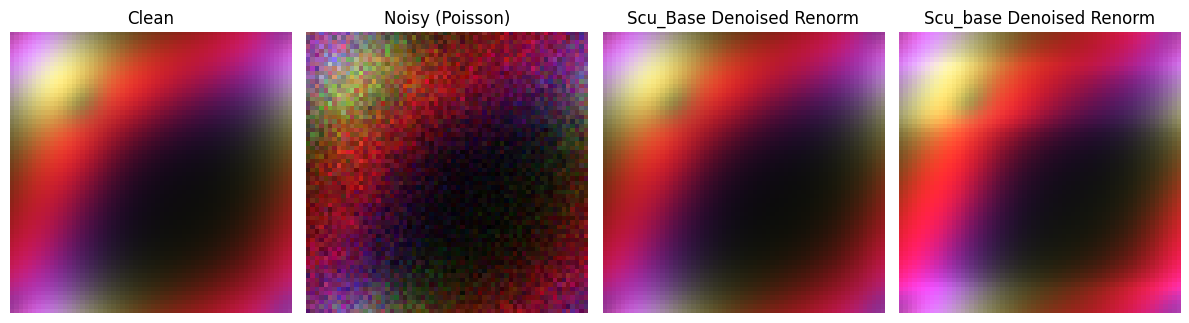

In [13]:
import matplotlib.pyplot as plt
x_clean = ref_d_rgb            # shape: (64, 64, 3), dtype: float32
                              # or whatever sampling parameter you want
x_noisy = x_train_rgb[0] 
x_denoised = np.transpose(scunet_denoised, (0,2,1))
print(x_denoised.shape)

# --- Plot ---
fig, axs = plt.subplots(1, 4, figsize=(12, 4))
axs[0].imshow(ref_d_rgb)
axs[0].set_title("Clean")
axs[0].axis("off")

axs[1].imshow(x_noisy)
axs[1].set_title("Noisy (Poisson)")
axs[1].axis("off")


axs[2].imshow(x_denoised)
axs[2].set_title("Scu_Base Denoised Renorm")
axs[2].axis("off")

def normalize_per_sample(x_rgb):
        max_vals = np.max(x_rgb, axis=(1, 2), keepdims=True)
        max_vals = np.where(max_vals == 0, 1.0, max_vals)  # Prevent div by zero
        return np.clip(x_rgb / (max_vals * 1), 0, 1)

#might need to be renormalized because max is no longer 1
renorm_den = normalize_per_sample(x_denoised)
axs[3].imshow(renorm_den)
axs[3].set_title("Scu_base Denoised Renorm")
axs[3].axis("off")

plt.tight_layout()
plt.show()


In [12]:
print(np.max(x_clean))
print(np.sum(x_clean,axis=(0,1,2)))
print()
print(np.max(x_noisy))
print(np.sum(x_noisy,axis=(0,1,2)))
print()
print(np.max(np.clip(x_denoised, 0, 1)))
print(np.sum(np.clip(x_denoised, 0, 1),axis=(0,1,2)))
print()
print(np.max(np.clip(renorm_den, 0, 1)))
print(np.sum(np.clip(renorm_den, 0, 1),axis=(0,1,2)))



1.0
3822.646322693739

1.0
2586.8709677419342

0.6670486
2585.9922

1.0
4454.4043


In [13]:
def jensen_shannon_divergence_loss(y_true, y_pred):
    y_t = tf.cast(y_true, tf.float32)
    y_p = tf.cast(y_pred, tf.float32)

    y_t = tf.reshape(y_t, [tf.shape(y_t)[0], -1])
    y_p = tf.reshape(y_p, [tf.shape(y_p)[0], -1])

    y_t /= tf.reduce_sum(y_t, axis=1, keepdims=True) + 1e-8
    y_p /= tf.reduce_sum(y_p, axis=1, keepdims=True) + 1e-8

    m = 0.5 * (y_t + y_p)

    kl_true = tf.reduce_sum(y_t * tf.math.log((y_t + 1e-8) / (m + 1e-8)), axis=1)
    kl_pred = tf.reduce_sum(y_p * tf.math.log((y_p + 1e-8) / (m + 1e-8)), axis=1)

    jsd = 0.5 * (kl_true + kl_pred)

    return tf.reduce_mean(jsd)

In [14]:
# --- Evaluation ---
print("\n>>> Evaluation Metrics on BM3D Denoised Image")

# 2-norm difference (before/after renorm)
norm_original = np.linalg.norm(x_denoised - x_clean)
norm_renormed = np.linalg.norm(renorm_den - x_clean)

print(f"2-norm (x_denoised vs ref_d_rgb): {norm_original:.4f}")
print(f"2-norm (renormalized vs ref_d_rgb): {norm_renormed:.4f}")

# Jensen-Shannon divergence setup
import tensorflow as tf
from tensorflow.keras.losses import KLDivergence

jsd_noisy = jensen_shannon_divergence_loss(tf.convert_to_tensor(x_noisy, dtype=tf.float32),
                                               tf.convert_to_tensor(x_clean, dtype=tf.float32))
jsd_original = jensen_shannon_divergence_loss(tf.convert_to_tensor(x_denoised, dtype=tf.float32),
                                               tf.convert_to_tensor(x_clean, dtype=tf.float32))
jsd_renormed = jensen_shannon_divergence_loss(tf.convert_to_tensor(renorm_den, dtype=tf.float32),
                                               tf.convert_to_tensor(x_clean, dtype=tf.float32))
print(f"JSD (x_noisy vs ref_d_rgb): {jsd_noisy.numpy():.6f}")
print(f"JSD (x_denoised vs ref_d_rgb): {jsd_original.numpy():.6f}")
print(f"JSD (renormalized vs ref_d_rgb): {jsd_renormed.numpy():.6f}")


>>> Evaluation Metrics on BM3D Denoised Image
2-norm (x_denoised vs ref_d_rgb): 14.5206
2-norm (renormalized vs ref_d_rgb): 8.3471


I0000 00:00:1753200531.370463  631085 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38366 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
I0000 00:00:1753200531.372481  631085 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38366 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
I0000 00:00:1753200531.375836  631085 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38366 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:82:00.0, compute capability: 8.0
I0000 00:00:1753200531.377545  631085 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 38366 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:c1:00.0, compute capability: 8.0


JSD (x_noisy vs ref_d_rgb): 0.012791
JSD (x_denoised vs ref_d_rgb): 0.000138
JSD (renormalized vs ref_d_rgb): 0.000138
